# Pre-stack seismic inversion of Marmousi model with IntraSeismic

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pylops
from pylops.utils.wavelets import *
from intraseismic.utils import *
from intraseismic.dataset import *
from intraseismic.model import *
from intraseismic.train import *
from torchinfo import summary
import torch
import json
import segyio
import cupy as cp

plt.rcParams['font.size'] = '9'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
set_seed(42)

True

## Data Loading

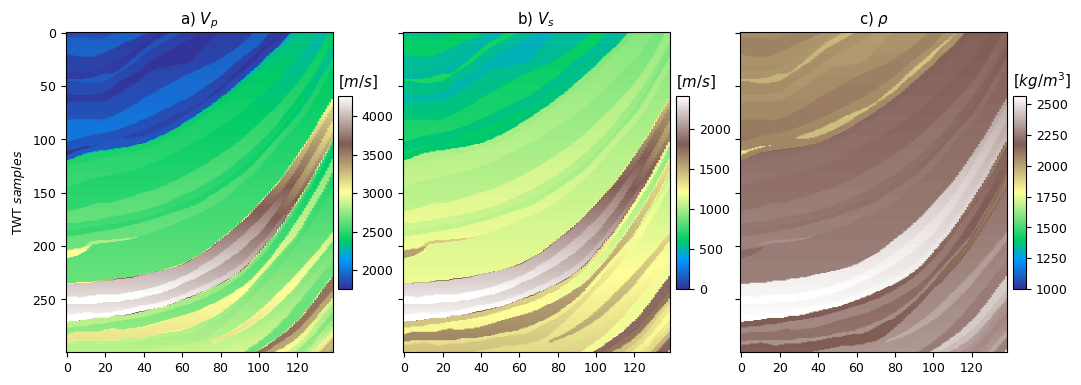

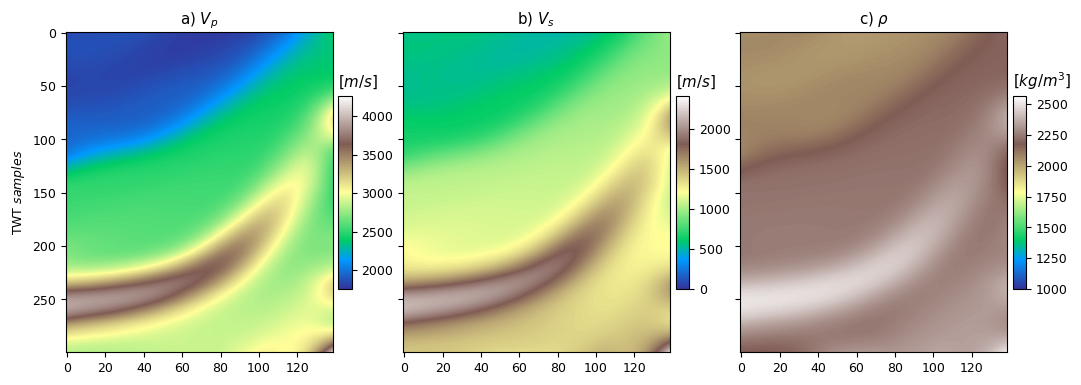

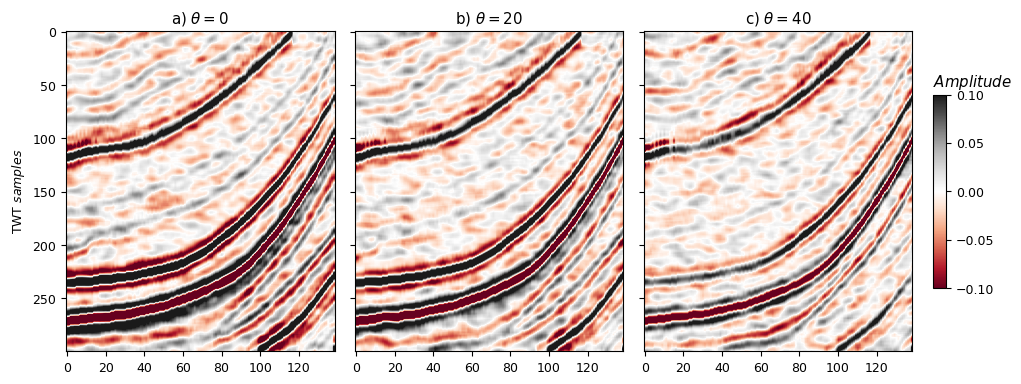

In [2]:
marm_pre = np.load('../../data/Marmousi_prestack.npz')
d_tensor = torch.from_numpy(marm_pre['dPPn']).float() # noisy pre-stack data
m_true = torch.from_numpy(marm_pre['m_true'].astype('float32')) # stack vp, vs, rho
mback = torch.from_numpy(np.log(marm_pre['mback']).astype('float32')).float()
wav = marm_pre['wav']
wav_cp = cp.asarray(wav, dtype='float32')
theta = marm_pre['theta'] # array of angles
theta_cp = cp.asarray(theta, dtype='float32')
ntheta = theta.shape[0]

dims = mback.shape[0], mback.shape[2]
vpvmin, vpvmax =  np.percentile(m_true[:, 0], [1,99])
_, vsvmax =  np.percentile(m_true[:, 1], [1,99])
_, rhovmax =  np.percentile(m_true[:, 2], [1,99])
vmins = [vpvmin, 0, 1000]
vmaxs = [vpvmax, vsvmax, rhovmax ]

plt.rcParams['font.size'] = '9'
plotprestackmodel(m_true, vmins, vmaxs)
plotprestackmodel(np.exp(mback), vmins, vmaxs)
plotprestackdata(d_tensor)

In [4]:
mback.shape

torch.Size([300, 3, 139])

## Data preparation

In [3]:
# General parameters
num_epochs = 1500
print_evry = 500
learning_rate = 1e-2

coords = create_coords(dims).to(device)
d =  d_tensor.to(device)
mback_ =  mback.to(device)

# Modeling Operator
vsvp = (np.exp(mback[:,1,:])/np.exp(mback[:,0,:]))[:, dims[1]//2]
vsvp_cp = cp.asarray(vsvp, dtype='float32')
G = pylops.avo.prestack.PrestackLinearModelling(wav_cp, theta_cp, vsvp=vsvp_cp, 
                                                nt0=dims[0], spatdims=(dims[1:]), 
                                                linearization="akirich", explicit=True)

G_torch = pylops.torchoperator.TorchOperator(G, device=device)

## IntraSeismic model setup

In [4]:
# IntraSeismic model setup
with open("config_marm_pre.json") as f:
	config = json.load(f)
    
# IntraSeismic network 
net1 = create_model(n_input_dims=len(dims), n_output_dims=1, config=config).to(device)
net2 = create_model(n_input_dims=len(dims), n_output_dims=1, config=config).to(device)
net3 = create_model(n_input_dims=len(dims), n_output_dims=1, config=config).to(device)

summary(net1)

Layer (type:depth-idx)                   Param #
Sequential                               --
├─Encoding: 1-1                          156,352
├─MLP: 1-2                               --
│    └─ModuleList: 2-1                   --
│    │    └─Linear: 3-1                  2,112
│    │    └─Linear: 3-2                  4,160
│    └─Linear: 2-2                       65
Total params: 162,689
Trainable params: 162,689
Non-trainable params: 0

## Training

In [5]:
# Initialize optimizer and losses
combined_parameters = list(net1.parameters()) + list(net2.parameters()) + list(net3.parameters())
optimizer = torch.optim.Adam(combined_parameters, lr=learning_rate)

# Training Loop
total_train_time = 0
epoch_losses = []
snr_vp = []
snr_vs = []
snr_rho = []

for epoch in range(1, num_epochs + 1):
    net1.train()
    net2.train()
    net3.train()
    loss, epoch_time = train_is_prestack_3nets(coords, d, mback_, ntheta, dims, G_torch,
                                   net1, net2, net3, optimizer,
                                   alphas = [5e-8, 1e-7, 1e-7],
                                   betas = [1e-6, 5e-4, 5e-3])
                                                                                       
    total_train_time += epoch_time
    epoch_losses.append(loss)
    net1.eval()
    net2.eval()
    net3.eval()
    with torch.no_grad():
        delta_model1 = net1(coords).float().view(-1).reshape(*dims)
        delta_model2 = net2(coords).float().view(-1).reshape(*dims)
        delta_model3 = net3(coords).float().view(-1).reshape(*dims)
        model1_ = delta_model1 + mback_[0:,0]
        model2_ = delta_model2 + mback_[0:,1]
        model3_ = delta_model3 + mback_[0:,2]
        snr_vp.append(SNR(m_true[:,0], torch.exp(model1_.cpu().detach())))
        snr_vs.append(SNR(m_true[:,1], torch.exp(model2_.cpu().detach())))
        snr_rho.append(SNR(m_true[:,2], torch.exp(model3_.cpu().detach())))
    
    if epoch % print_evry == 0:
        print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss:.6f}, Training Time: {total_train_time:.2f}s')

print(f'Training completed in {total_train_time:.3f} seconds.')

Epoch [500/1500], Loss: 0.000367, Training Time: 2.36s
Epoch [1000/1500], Loss: 0.000361, Training Time: 4.71s
Epoch [1500/1500], Loss: 0.000359, Training Time: 7.06s
Training completed in 7.055 seconds.


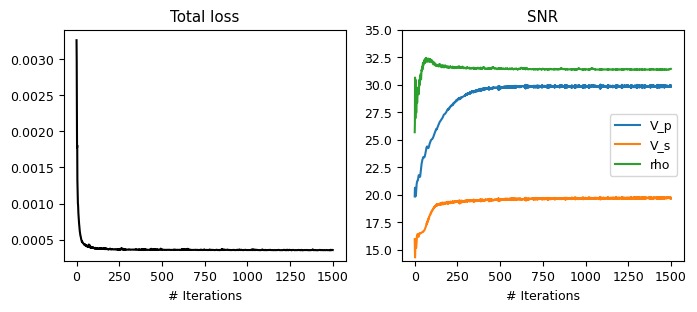

In [6]:
fig, ax = plt.subplots(1,2, figsize=(8,3))
ax[0].plot(epoch_losses, 'k')
ax[0].set_xlabel('# Iterations')
ax[0].set_title('Total loss')
ax[1].plot(snr_vp,  label='V_p')
ax[1].plot(snr_vs,  label='V_s')
ax[1].plot(snr_rho, label='rho')
ax[1].set_xlabel('# Iterations')
ax[1].set_ylim(14,35)
ax[1].set_title('SNR')
plt.legend()

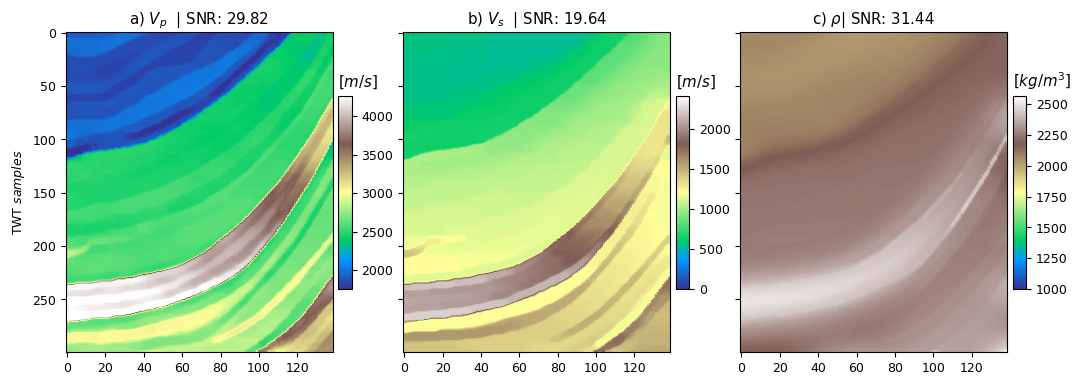

In [11]:
net1.eval()
net2.eval()
net3.eval()
with torch.no_grad():
    delta_model1 = net1(coords).float().view(-1).reshape(*dims)
    delta_model2 = net2(coords).float().view(-1).reshape(*dims)
    delta_model3 = net3(coords).float().view(-1).reshape(*dims)
    model1_ = delta_model1 + mback_[0:,0]
    model2_ = delta_model2 + mback_[0:,1]
    model3_ = delta_model3 + mback_[0:,2]
    
model_cpu = torch.exp(torch.stack([model1_.cpu(), model2_.cpu(), model3_.cpu()], dim=1)) # Sum the background model
plotprestackmodel(model_cpu, vmins, vmaxs, mtrue=m_true, gt=True)

In [9]:
330/4, 82.5*.70, 50*(1.04**16), 20*(1.1**16)

(82.5, 57.74999999999999, 93.64906228635967, 91.89945972714443)

(300.0, 0.0)

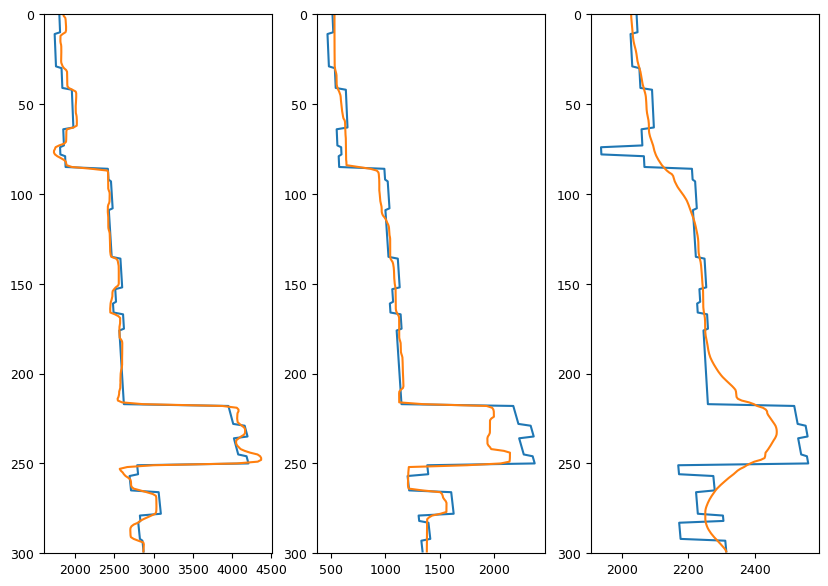

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(10, 7))
vax = np.arange(m_true.shape[0])
ax[0].plot(m_true[:,0,60],vax)
ax[0].plot(model_cpu[:,0,60], vax)
ax[0].set_ylim(300,0)
ax[1].plot(m_true[:,1,60],vax)
ax[1].plot(model_cpu[:,1,60], vax)
ax[1].set_ylim(300,0)
ax[2].plot(m_true[:,2,60], vax)
ax[2].plot(model_cpu[:,2,60], vax)
ax[2].set_ylim(300,0)